# Bunny Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ScoreMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, MultiDeepCK
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, traj_to_line

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [8]:
key = jax.random.PRNGKey(0)

## Data

In [13]:
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

bunny_o3d = o3d.data.BunnyMesh()
bunny = o3d_mesh_to_pv(bunny_o3d)
bunny.points = min_max_scale(bunny.points)
bunny_bounds = bunny.bounds
bunny_bounds = jnp.array(bunny_bounds).reshape(3, 2).T
bounds = bunny_bounds * 1.1

point_in_mesh_approx = point_in_mesh_fn(bunny, 60, bounds=bounds)

In [14]:
points = jnp.array(bunny.points)

X_grid = grid(bounds, N=50, flatten=False)
X_flat = grid(bounds, N=50)
uni_pdf = lambda x: 1 / x.shape[0]

n_samples = 2000
samples = jax.random.choice(key, points, shape=(n_samples,), replace=False)
prob_s = jnp.ones(n_samples) / n_samples

n_traj = 300
# traj_init = jnp.linspace(bounds[0], bounds[1], num=n_traj, endpoint=True)
traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)

In [15]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

def aux_loss_fn(particles, beta=1e-3):
    traj_loss = traj_loss_fn(particles) 
    clipping_loss = point_in_mesh_approx(particles).mean() * 100
    return traj_loss + clipping_loss 

In [16]:
def point_in_mesh_true(particles):
    points = pv.PointSet(particles)
    distances = points.compute_implicit_distance(bunny)["implicit_distance"]
    return jnp.array(distances)

### Initial Metric and Plots

In [17]:
pdf_recon_init = ergodic_metric(traj_init, bounds, n_modes=10, n_per_dim=50)
# pdf_recon_init = pdf_recon_init / jnp.sum(pdf_recon_init)
pdf_true = jax.vmap(uni_pdf)(X_flat)
print(f"Initial ergodic metric: {jnp.mean((pdf_recon_init - pdf_true)**2)}")

Initial ergodic metric: 915.8111431762178


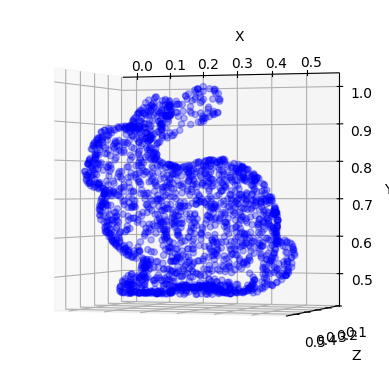

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.view_init(70, 0, 90)
ax.scatter(samples[:, 0], samples[:, 1], samples[:,2], c='b', marker='o', alpha=0.3)

# # Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

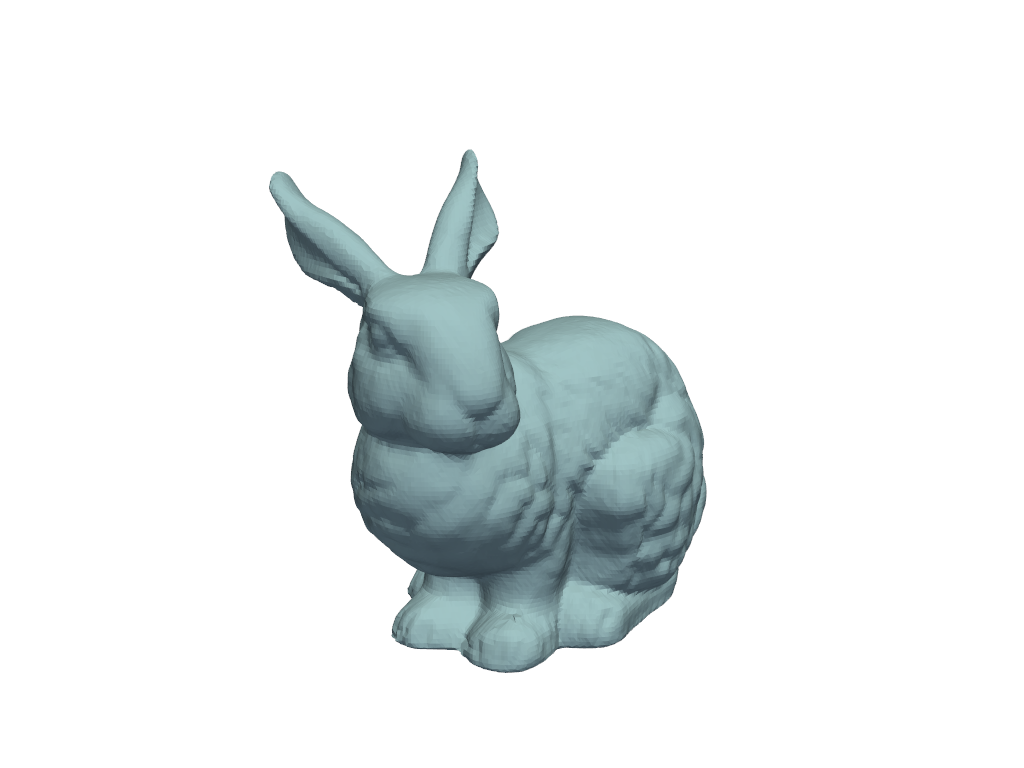

In [20]:
traj_init_points = pv.PointSet(traj_init)

pl = pv.Plotter(notebook=True)
pl.add_mesh(bunny, show_edges=False)
# pl.add_points(traj_init_points, color='r', point_size=10)
pl.camera.roll = 0
pl.camera.elevation = -20
pl.camera.azimuth = 270
pl.show(jupyter_backend='pythreejs')

## Model Definitions

In [25]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z, t.q_params, t.l]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [26]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))    
    mmd_init = ImpCloudMMD(k_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l, R=R)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [27]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_layers", 3)
    d_hidden = kwargs.get("d_hidden", 15)
    d_out = kwargs.get("out_dim", 8)
    n_kernels = kwargs.get("n_kernels", 3)
    k_init = MultiDeepCK(key, in_dim=d, out_dim=d_out, d_hidden=d_hidden, n_layers=n_hidden, n_kernels=n_kernels)
    mmd_init = ImpCloudMMD(k_init, traj_init)
    
    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    training_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale#, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=training_param_fn,
        lowrank=False, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale, t.k.epsilon, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    # return mmd_init, mmd_power, mmd_score
    return mmd_init, mmd_power, mmd_gp, mmd_score


In [28]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [22]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [23]:
rbf_power_params = {
    'epochs': epochs_k, 'lr': lr, 'verbose': True
}
rbf_gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': True
}
rbf_score_params = {
    'lr': 1e-3, 'q': 'normal', #'q_params': bounds,
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

In [29]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
epoch 0,loss: -0.05621500247549622
epoch 50,loss: -0.052618521107039476
epoch 100,loss: -0.04876309093448742
epoch 150,loss: -0.044737509098704456
epoch 200,loss: -0.040713917662791706
epoch 250,loss: -0.03689888509018255
epoch 300,loss: -0.03347850407924688
epoch 350,loss: -0.03057068949763101
epoch 400,loss: -0.028205519245137825
epoch 450,loss: -0.026336222115476322
epoch 500,loss: -0.02487011841253656
epoch 550,loss: -0.0237032530848388
epoch 600,loss: -0.022745047326785083
epoch 650,loss: -0.021929545597468392
epoch 700,loss: -0.021215291449927773
epoch 750,loss: -0.020579290049084632
epoch 800,loss: -0.020010128634158315
epoch 850,loss: -0.01950220729422381
epoch 900,loss: -0.019052195961101404
epoch 950,loss: -0.01865686358263455
epoch 1000,loss: -0.01831284043362321
epoch 1050,loss: -0.01801596494154476
epoch 1100,loss: -0.017761932998812072
epoch 1150,loss: -0.017546065028151734
epoch 1200,loss: -0.01736384417446764
epoch 1250,loss: -0.0172109453974261
epoch 130

In [30]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.14497812 0.14862794 0.10205   ]
Scale: [0.09399379 0.14549269 0.27639073]
Scale: [0.5715666  0.6016114  0.40760514]
Scale: [0.05772753 0.06336469 0.05578571]


Train trajectories with MMD:

In [ ]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds,
        solver_params={'tol': 1e-5, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 1000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (rbf_traj_init.w, rbf_power_traj.w, rbf_gp_traj.w, rbf_score_traj.w)

### RFF

In [37]:
rff_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': True
}
rff_gp_params = {
    "epochs": 3000, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-3, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [38]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples, prob_s, bounds, rff_power_params, rff_gp_params, rff_score_params
)

Training power
epoch 0,loss: -0.07610990879192592
epoch 50,loss: -0.013282358130481906
epoch 100,loss: 0.03612900003279182
epoch 150,loss: 0.07633362614813717
epoch 200,loss: 0.10989628300149007
epoch 250,loss: 0.13824465486908757
epoch 300,loss: 0.16212028584124577
epoch 350,loss: 0.1821506245031576
epoch 400,loss: 0.1989120752019439
epoch 450,loss: 0.21289184973692413
epoch 500,loss: 0.22453047510521457
epoch 550,loss: 0.23426862187243816
epoch 600,loss: 0.24252352941073296
epoch 650,loss: 0.24964177001492388
epoch 700,loss: 0.2558691058008047
epoch 750,loss: 0.26132327218073315
epoch 800,loss: 0.2660219018911972
epoch 850,loss: 0.27000701641944247
epoch 900,loss: 0.27339506592043555
epoch 950,loss: 0.27630710574337664
epoch 1000,loss: 0.2788286809393752
epoch 1050,loss: 0.2810346022517185
epoch 1100,loss: 0.2830108174307149
epoch 1150,loss: 0.28484273842465047
epoch 1200,loss: 0.28658478248145464
epoch 1250,loss: 0.2882393524684278
epoch 1300,loss: 0.2897792233665664
epoch 1350,loss

In [39]:
rff_models = (rff_init, rff_power, rff_gp, rff_score)

In [40]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 5000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (rff_traj_init.w, rff_power_traj.w, rff_gp_traj.w, rff_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Deep Kernel

In [45]:
deep_power_params = {
    'epochs': 1000, 'lr': 1e-3, 'verbose': True
}
deep_gp_params = {
    "epochs": 1, 'diag': 1e-4, 'lr': 1e-3, 'verbose': False
}
deep_score_params = {
    'lr': 1e-3, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [46]:
# deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
#     key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
# )
deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
    key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_score)

Training power
epoch 0,loss: -0.11024360793710593
epoch 50,loss: -0.08410577323609289
epoch 100,loss: 0.16234701369846066
epoch 150,loss: 0.28686435258532533
epoch 200,loss: 0.3237519212657243
epoch 250,loss: 0.34557493443038656
epoch 300,loss: 0.36417276931415327
epoch 350,loss: 0.3826991656197861
epoch 400,loss: 0.3992295479588824
epoch 450,loss: 0.41026222399709955
epoch 500,loss: 0.4169927203293182
epoch 550,loss: 0.42199162421612935
epoch 600,loss: 0.42716609345511874
epoch 650,loss: 0.4319587810078128
epoch 700,loss: 0.4358132079594055
epoch 750,loss: 0.4394075156523567
epoch 800,loss: 0.4426919636632324
epoch 850,loss: 0.44537935073442136
epoch 900,loss: 0.44768317235758304
epoch 950,loss: 0.4497169870021229
Training gp
Training score
epoch 0,loss: 24819.815819401087
epoch 50,loss: 160.85908655113963
epoch 100,loss: 58.878430099174814
epoch 150,loss: 76.37099677787775
epoch 200,loss: 49.087830542917914
epoch 250,loss: 53.89981769556276
epoch 300,loss: 33.84056755024339
epoch 350

In [48]:
deep_traj_init, deep_power_traj, deep_score_traj = train_trajectories(
        key, deep_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
deep_trajectories = (rff_traj_init.w, deep_power_traj.w, deep_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 1000}
Training model 2
{'tol': 1e-05, 'maxiter': 1000}
Training model 3
{'tol': 1e-05, 'maxiter': 1000}


## Visualize

In [33]:
bunny_camera = {"roll": 0, "elevation": -20, "azimuth": -60}

### RBF

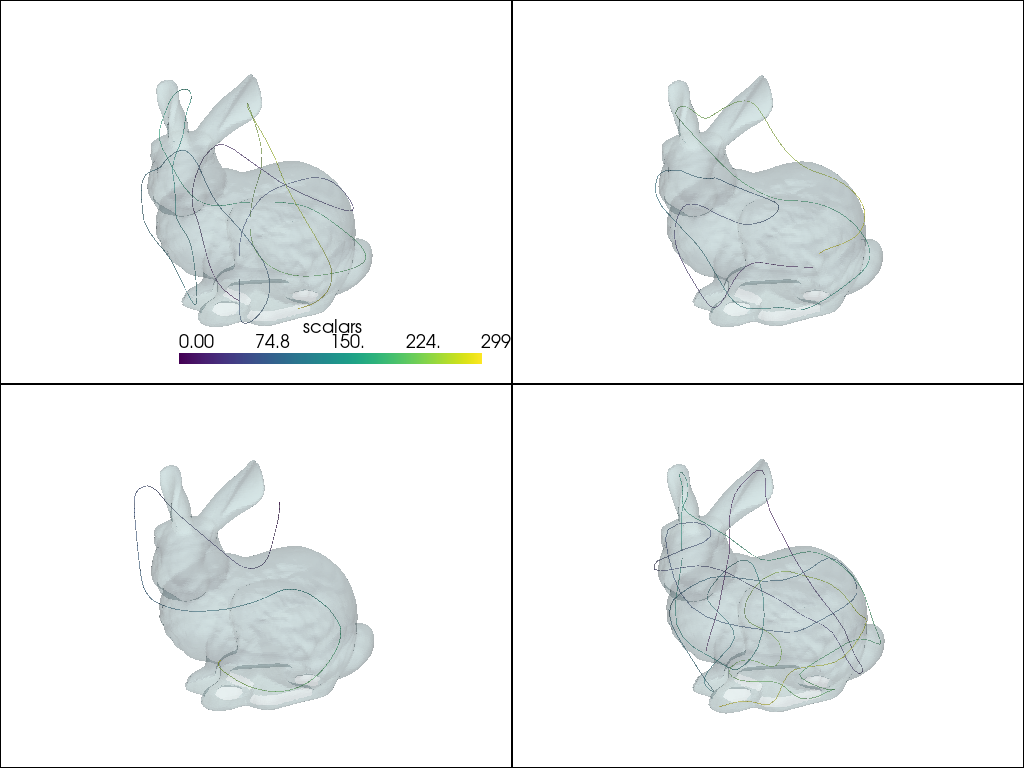

In [34]:
plot_multi_3d_traj_pv(bunny, rbf_trajectories, shape=(2,2), camera_pos=bunny_camera, color=True)

In [ ]:
import numpy as np
pl = pv.Plotter(notebook=True)
scaler = 1.0

line = lines[3]
line.points = line.points * scaler
tube = line.tube(radius=0.002).smooth_taubin()

# scalars="von Mises stress",
pl.add_mesh(bunny, opacity=0.45, cmap='Blues', show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, color="red", show_scalar_bar=False)
pl.add_points(pv.PointSet(lines[3].points), color='black', point_size=6, render_points_as_spheres=True)
pl.camera.tight(0.3)
pl.camera.azimuth = 320
pl.camera.elevation = 16
# pl.camera.roll = 0
# pl.camera.view_angle = 
pl.save_graphic("aero_rbf_score.svg")
pl.show(jupyter_backend='pythreejs')


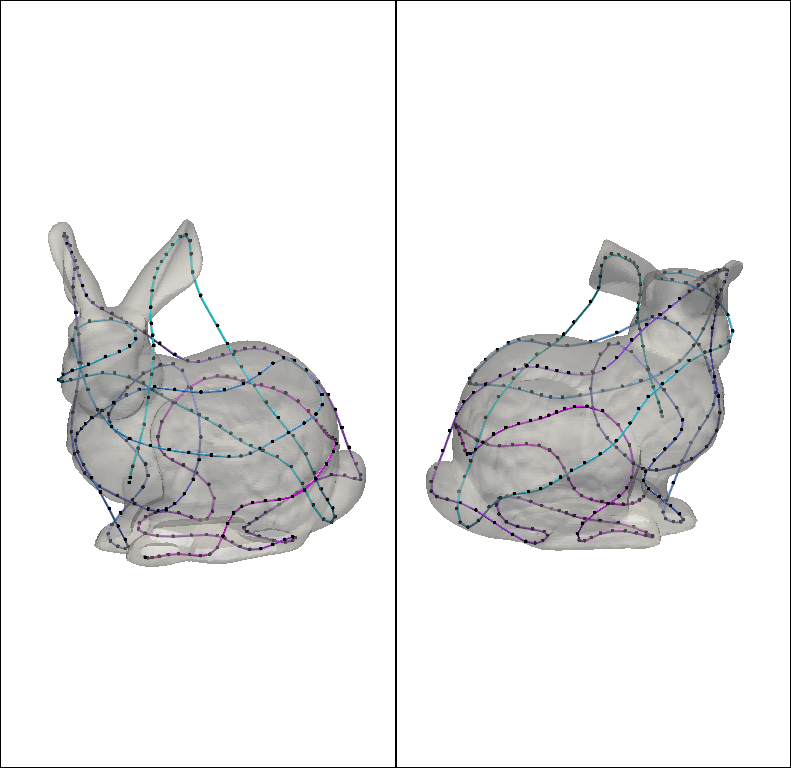

In [98]:
# camera_pos=bunny_camera
import numpy as np
pl = pv.Plotter(notebook=True, shape=(1, 2))
scaler = 1.0

line = traj_to_line(rbf_score_traj.w)
line.points = line.points * scaler
tube = line.tube(radius=0.002).smooth_taubin()

# scalars="von Mises stress",
pl.subplot(0, 0)
pl.add_mesh(bunny, opacity=0.45, color='lightgrey', show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, cmap="cool", show_scalar_bar=False)
pl.add_points(pv.PointSet(line.points), color='black', point_size=4, render_points_as_spheres=True)
pl.camera.tight(0.2)
pl.camera.azimuth = 340
pl.camera.elevation = 16
# pl.camera.roll = 0
# pl.camera.view_angle = 
# pl.save_graphic("bunny_rbf_score.pdf")

pl.subplot(0, 1)
pl.add_mesh(bunny, opacity=0.45, color='lightgrey', show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, cmap="cool", show_scalar_bar=False)
pl.add_points(pv.PointSet(line.points), color='black', point_size=4, render_points_as_spheres=True)
pl.camera.tight(0.2)
pl.camera.azimuth = 160
pl.camera.elevation = 16
# pl.camera.roll = 0
# pl.camera.view_angle = 
pl.save_graphic("bunny_rbf_score.svg")

pl.show(jupyter_backend='pythreejs')


### RFF

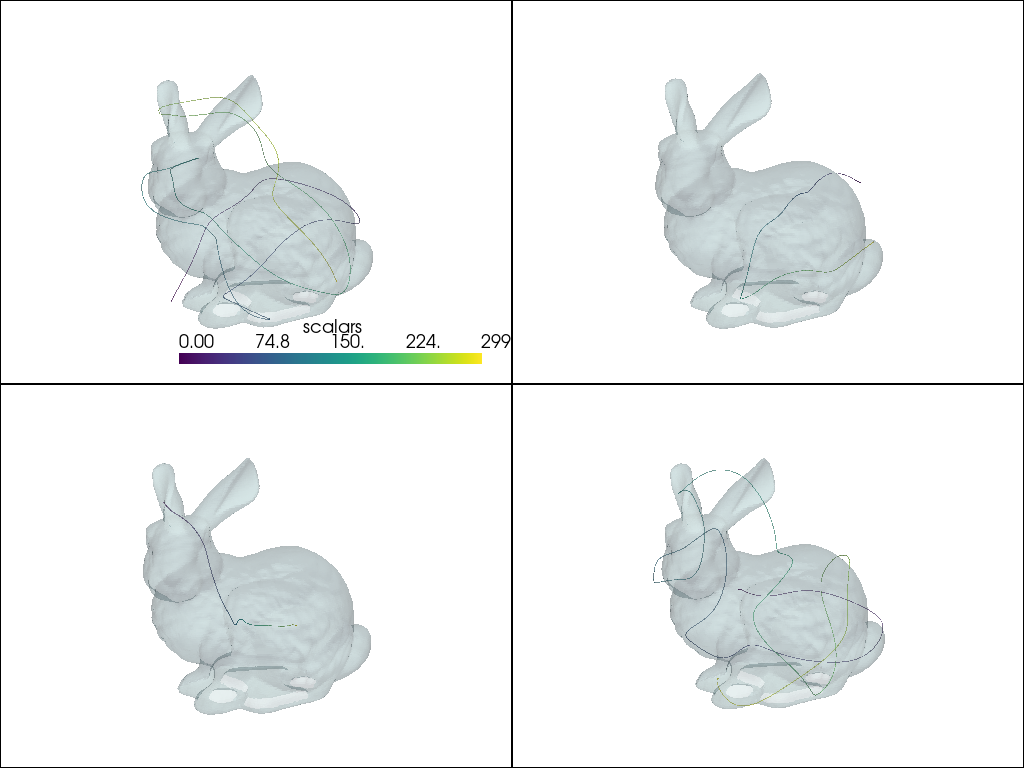

In [41]:
plot_multi_3d_traj_pv(bunny, rff_trajectories, shape=(2,2), camera_pos=bunny_camera, color=True)

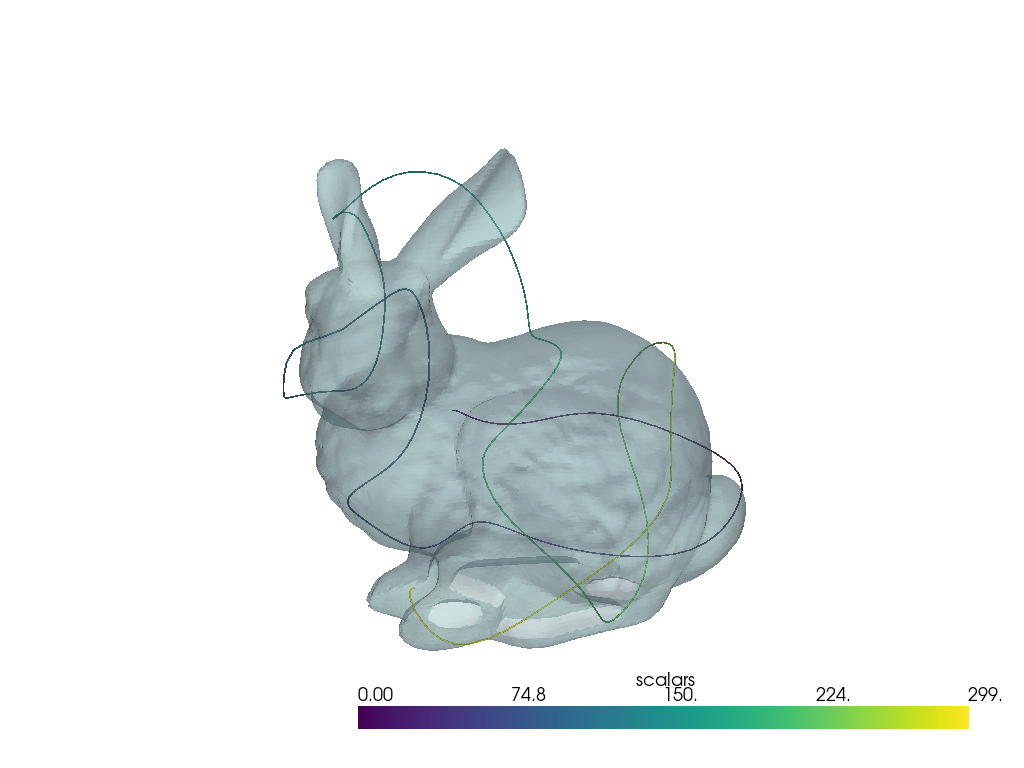

In [42]:
plot_3d_trajectory_pv(bunny, rff_score_traj.w, camera_pos=bunny_camera, color=True, opacity=0.5)

### Deep Kernels

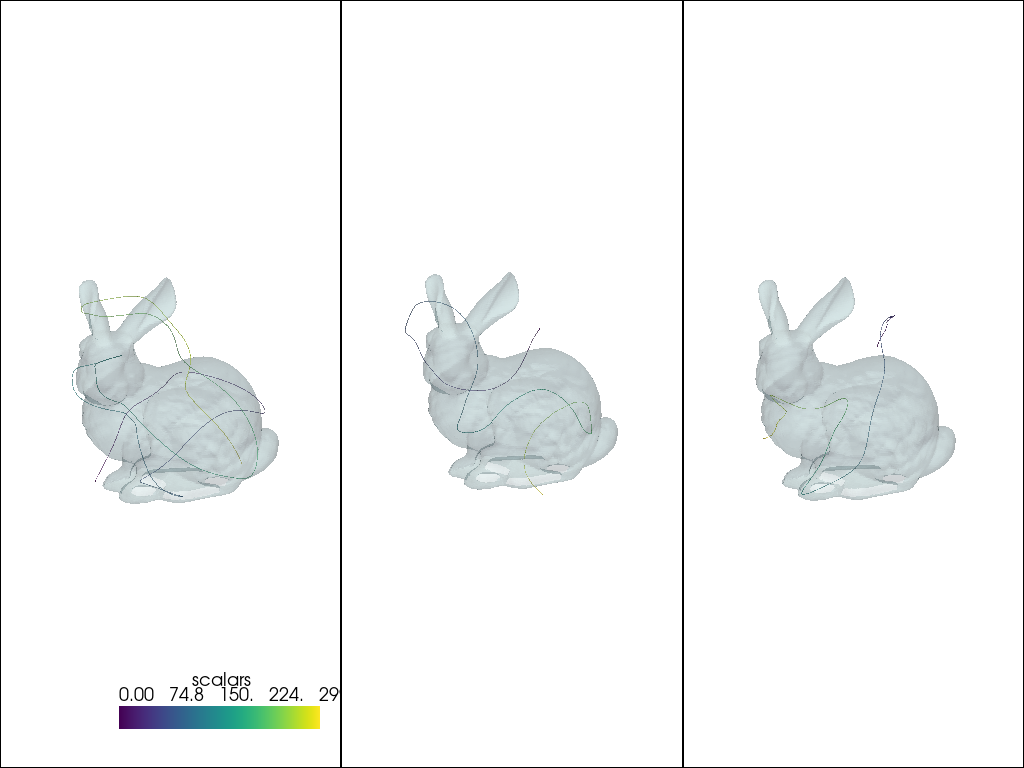

In [49]:
plot_multi_3d_traj_pv(bunny, deep_trajectories, camera_pos=bunny_camera, color=True)

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [24]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))